In [1]:
import scanpy as sc
import os 

from omegaconf import OmegaConf as om
from mosaicfm.utils.util import compute_lisi_scores
from inference.predict_embeddings import predict_embeddings

/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/megablocks/layers/weight_parallel.py:66: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd
/usr/lib/python3/dist-packages/megablocks/layers/weight_parallel.py:88: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_bwd
/usr/lib/python3/dist-packages/megablocks/layers/weight_parallel.py:130: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd
/usr/lib/python3/dist-packages/megablocks/l

In [ ]:
# Define Config 
cfg = {
  "paths": {
    "model_dir": "/tahoe/data/ckpts/MFM-v2/release/mosaicfm-3b-prod-cont-MFMv2",
    "adata_input":  "/tahoe/data/datasets/benchmark/CCLE/ccle.h5ad", #"/tahoe/data/datasets/benchmark/kim2020_lung/kim_test.h5ad", #"/tahoe/data/datasets/benchmark/tahoe/Tahoe50k_test.h5ad", , 
    "drug_to_id_path": "/tahoe/gits/mosaicfm-release/drug_to_id_pad.json",
    "drug_fps_path": "/tahoe/gits/mosaicfm-release/drug_fps_pad.npy"
  },
  "data": {
    "cell_type_key": "OncotreeLineage" , #"cell_type" , #"cell_line",  
    "gene_id_key": "feature_id" #"ensembl_id"  #""  
  },
  "predict": {
    "seq_len_dataset": 8192,  #2048
    "return_genes": False,  # Whether to extract gene embeddings
    "save": False,
    "use_chem_inf": False
  },
  "plot":
  {
    "save_dir": "./figures"
  }
}
cfg = om.create(cfg)
model_name = cfg.paths.model_dir.split("/")[-1]
model_name

'mosaicfm-3b-prod-cont-MFMv2'

In [8]:
# Extract embeddings
adata, cell_array, gene_array = predict_embeddings(cfg)
adata.obsm[model_name] = cell_array


Error downloading the file from s3://vevo-ml-datasets/mosaicfm_v2/datasets/drug_fps_pad.npy: Unable to locate credentials


/tahoe/gits/mosaicfm-release/mosaicfm/utils/util.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt)["state"]["model"])


KeyboardInterrupt: 

LISI score: 4.2697


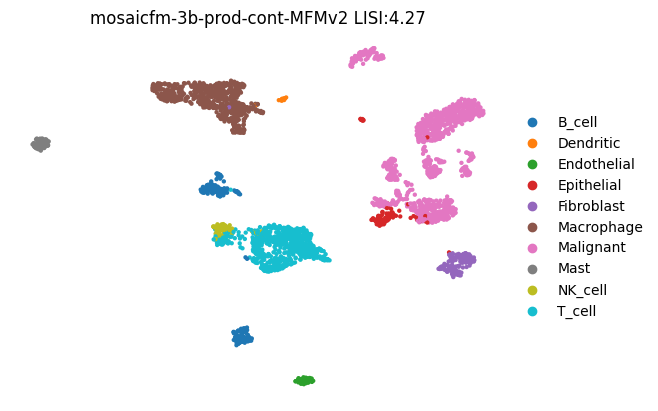

In [4]:
# Calculate LISI

cell_type_key = cfg.data.cell_type_key
lisi_score = compute_lisi_scores(cell_array, 
                                adata.obs[cell_type_key].values, 
                                20) 
print(f"LISI score: {lisi_score:.4f}")


# Plotting
adata.obs[cell_type_key] = adata.obs[cell_type_key].astype('category')
sc.pp.neighbors(adata, use_rep=model_name)
sc.tl.umap(adata)
fig = sc.pl.umap(adata, 
           color=[cell_type_key], 
           frameon=False, 
           wspace=0.4, 
           title=[f"{model_name} LISI:{lisi_score:.2f}"],
           return_fig=True)

# Save figure
save_dir = cfg.plot.save_dir
os.makedirs(save_dir, exist_ok=True)
fig.savefig(f"{save_dir}/{model_name}_{cfg.paths.adata_input.split('/')[-1].replace('.h5ad','')}.png", dpi=300, bbox_inches="tight")

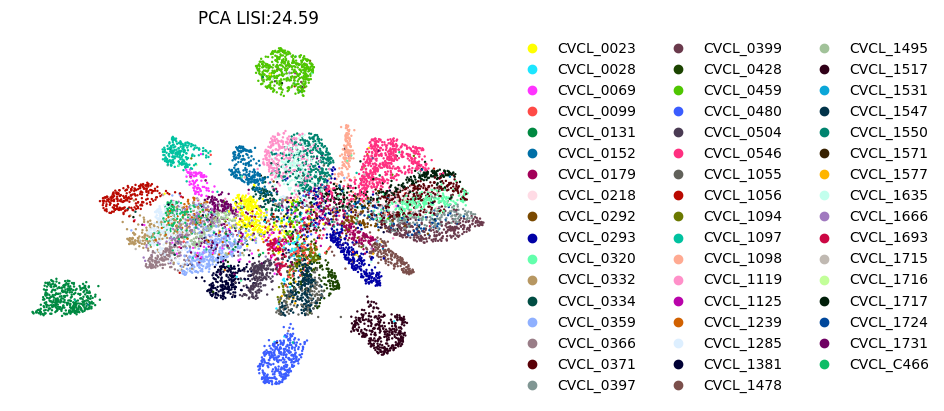

In [23]:
#PCA

sc.pp.normalize_total(adata, target_sum=10000, inplace=True)
sc.pp.log1p(adata)
sc.tl.pca(adata, n_comps=15)
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

lisi_score = compute_lisi_scores(adata.obsm["X_pca"], adata.obs[cell_type_key], 20)
fig = sc.pl.umap(adata, color=cell_type_key, title=f"PCA LISI:{lisi_score:.2f}", return_fig=True, frameon=False,)

fig.savefig(f"{save_dir}/PCA_{cfg.paths.adata_input.split('/')[-1].replace('.h5ad','')}.png", dpi=300, bbox_inches="tight")
